---
title: "Assignment 2"
author: "Sangwon Ju, SNU GSPA"
date: 'NOV/06/2022'
format: 
    html:
        code-overflow: wrap
        code-fold: true
categories:
   "Machine Learning & Deep Learning for Data Science (2022 Fall)" 
image: "20221106_185811.png"
---

LDA, QDA ~ Unsupervised Learning

<h3 align="center"> Machine Learning & Deep Learning for Data Science <br> Assignment 2 </h3> 

<h5 align="right"> 행정대학원 정책학전공 2021-29725 주상원   </h5> 

# 0. 준비

In [2]:
# Loading Packages
import os
import time
from time import time
from IPython.display import display, Math, Latex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.linear_model as skl_lm
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.cluster import hierarchy
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf


Reference Repositiory: https://github.com/JWarmenhoven/ISLR-python

# 1. 
In this problem, you will use the OnlineAd training data set attached in the assignment (OnlineAd X train.csv and OnlineAd Y train.csv). The feature matrix OnlineAd X train.csv contains 1452 observations, where each row represents a different user with 251 features that summarize the user characteristics and previous browsing history. These 251 features have been anonymized and normalized. Hence, each feature’s interpretation is hidden for analysis. (i.e., you don’t have to worry about the meaning of each feature.) There are two online advertisements, A and B, with which this experiment was performed. In each observation, a user clicks either A or B, or she may not click anything. She cannot click on two ads at the same time. This click response is recorded in OnlineAd Y train.csv, where each row contains information on which ad was clicked (or whether a user clicked nothing). A no click response is recorded as 1 in the first column in OnlineAd Y train.csv, a click on A is 1 in the second column, and likewise for a click on B is 1 in the third column. Note that 0 means non-chosen options by the user. Hence, each row sum of OnlineAd Y train.csv is exactly 1. Each row of OnlineAd Y train.csv is the click response for the corresponding user in the corresponding row of OnlineAd X train.csv

## Loading Dataset

In [3]:
# Set Work Directory
print("Before Directory: %s"%os.getcwd())
os.chdir("E:/OneDrive - SNU/r")
print("After Directory: %s"%os.getcwd())

Before Directory: e:\OneDrive - SNU\(B) 대학원\수업\2022 2학기\데이터사이언스를위한머신러닝과딥러닝\과제2
After Directory: E:\OneDrive - SNU\r


In [4]:
# Read Dataset
y_train=pd.read_csv("OnlineAd_Y_train.csv",header=None)
x_train=pd.read_csv("OnlineAd_X_train.csv",header=None)
x_test=pd.read_csv("OnlineAd_X_test.csv",header=None)
# Check if there is missing value
print("Total missing variable: ",x_test.isnull().sum().sum()) # no missing value
print("Total missing variable: ",x_train.isnull().sum().sum()) # no missing value
print("Total missing variable: ",y_train.isnull().sum().sum()) # no missing value
# Dimension
print("xdim: ", x_train.shape)
print("ydim: ", y_train.shape)
print("xtestdim: ", x_test.shape)

Total missing variable:  0
Total missing variable:  0
Total missing variable:  0
xdim:  (1452, 251)
ydim:  (1452, 3)
xtestdim:  (300, 251)


In [5]:
x_colname=[]
for i in np.arange(0,251):
    x_colname.append(f"x_{i}")
x_train.columns=x_colname
y_colname=["No","A","B"]
y_train.columns=y_colname
# no click response: No, second columnn: A, third column: B

# make array for the x_train
x_train2=x_train.to_numpy()
display(x_train2[:10])
# make array for the y_train
y_train2=np.array(np.where(y_train["No"] == 1, 0, np.where(y_train["A"] == 1, 1, 2)))
display(y_train2[:10])

array([[ 9.6870e-01, -3.9480e-01, -5.4670e-01, ...,  5.1620e-01,
        -3.3300e-01,  4.6600e-02],
       [-4.6690e-01,  5.2220e-01,  6.9560e-01, ..., -7.5100e-02,
        -1.6022e+00,  4.1810e-01],
       [-1.1187e+00,  2.3400e-01, -5.5800e-02, ...,  2.4260e-01,
        -1.4561e+00,  3.0000e-03],
       ...,
       [ 6.9000e-03,  2.6000e-03, -1.2000e-03, ..., -1.0200e-02,
        -3.7000e-03, -1.8400e-02],
       [ 4.0000e-02,  5.2400e-02,  5.3200e-02, ...,  3.9400e-02,
        -7.8000e-03,  7.9500e-02],
       [-5.8900e-01, -1.6920e-01, -7.9870e-01, ..., -4.2110e-01,
        -8.0060e-01,  2.2250e-01]])

array([0, 2, 0, 0, 0, 1, 0, 2, 0, 2])

In [25]:
from collections import Counter
display(y_train.value_counts())
display(Counter(y_train2))

No   A    B  
1.0  0.0  0.0    822
0.0  0.0  1.0    353
     1.0  0.0    277
dtype: int64

Counter({0: 822, 2: 353, 1: 277})

In [6]:
from sklearn.metrics import f1_score
# CV
cv_5 = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2022)

# Grid Search: Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

Citation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

## (a) 
[40 pts] Using OnlineAd X train.csv and OnlineAd Y train.csv, train multiple models that you learned in class. You may try a model which is modified from the models we covered in the first half of the course. You are allowed to use the existing packages, but make sure to clearly explain what models are used. Report the training results. What metric did you use? How do different models perform on the training data?



### 1) multinomial logistic regression
citation: https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

In [148]:
# multinomial logistic regression
model_mlogit_l = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
model_mlogit_s = LogisticRegression(multi_class='multinomial', solver='saga',max_iter=1000)
#  ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. (already scaled)

# evaluate the model and collect the scores
accuracy_mlogit_s = cross_val_score(model_mlogit_l, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_mlogit_s = cross_val_score(model_mlogit_l, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)
accuracy_mlogit_l = cross_val_score(model_mlogit_s, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_mlogit_l= cross_val_score(model_mlogit_l, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean Accuracy_saga: %.3f (%.3f)' % (np.mean(accuracy_mlogit_s), np.std(accuracy_mlogit_s)))
print('Mean f1 weighted saga: %.3f (%.3f)' % (np.mean(f1w_mlogit_s), np.std(f1w_mlogit_s)))
print('Mean Accuracy_lbfgs: %.3f (%.3f)' % (np.mean(accuracy_mlogit_l), np.std(accuracy_mlogit_l)))
print('Mean f1 weighted_lbfgs: %.3f (%.3f)' % (np.mean(f1w_mlogit_l), np.std(f1w_mlogit_l)))

Mean Accuracy_saga: 0.548 (0.023)
Mean f1 weighted saga: 0.542 (0.022)
Mean Accuracy_lbfgs: 0.549 (0.024)
Mean f1 weighted_lbfgs: 0.542 (0.022)


In [159]:
model_mlogit_l.fit(x_train2, y_train2)
y_pred_mlogit = model_mlogit_l.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_mlogit, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_mlogit),2))


Training result (f1_weighted):  0.72
Training result (accuracy):  0.73


### 2) Support vector machine

In [63]:
from sklearn.svm import SVC

In [10]:
# SVM: linear
model_svm_l_g = SVC(kernel='linear',random_state=2022)
parameters= {'C': [0.0001, 0.001,0.01, 0.1]}

# Find Best Parameter C
model_svm_l = GridSearchCV(model_svm_l_g, param_grid = parameters, cv = cv_5, n_jobs=-1, scoring='f1_weighted')

model_svm_l.fit(x_train2, y_train2)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=2022),
             estimator=SVC(kernel='linear', random_state=2020), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1]},
             scoring='f1_weighted')

In [12]:
model_svm_l_result = pd.DataFrame(model_svm_l.cv_results_['params'])
model_svm_l_result['mean_f1_weighted_score'] = model_svm_l.cv_results_['mean_test_score']
model_svm_l_result['std_f1_weighted_score'] = model_svm_l.cv_results_['std_test_score']
display(model_svm_l_result.sort_values(by='mean_f1_weighted_score', ascending=False))

,C,mean_f1_weighted_score,std_f1_weighted_score
2,0.0100,0.561710,0.020828
1,0.0010,0.554006,0.019123
3,0.1000,0.550008,0.021432
0,0.0001,0.464239,0.016612


In [161]:
model_svm_linear = SVC(kernel='linear',C=0.01,random_state=2022)

# evaluate the model and collect the scores
accuracy_svm_linear = cross_val_score(model_svm_linear, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_svm_linear = cross_val_score(model_svm_linear, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_svm_linear), np.std(f1w_svm_linear)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_svm_linear), np.std(accuracy_svm_linear)))


Mean f1_weighted: 0.562 (0.021)
Mean Accuracy: 0.645 (0.018)


In [162]:
# training result
model_svm_linear.fit(x_train2, y_train2)
y_pred_svml = model_svm_linear.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_svml, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_svml),2))


Training result (f1_weighted):  0.57
Training result (accuracy):  0.66


In [15]:
# SVM: rbf
model_svm_r_g = SVC(kernel='rbf',random_state=2022)
parameters= {
    'C': [ 0.1, 1, 10,100, 500,1000], 'gamma': [0.00001, 0.00005, 0.0001, 0.0025, 0.0005, 0.001, 0.01]
    }

# run grid search
model_svm_r = GridSearchCV(model_svm_r_g, param_grid = parameters, cv = cv_5, n_jobs=-1,scoring='f1_weighted')
start = time()
model_svm_r.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_svm_r.cv_results_["params"]))
)
report(model_svm_r.cv_results_)
# Find Best Parameter C and gamma

GridSearchCV took 34.72 seconds for 42 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.579 (std: 0.024)
Parameters: {'C': 10, 'gamma': 0.01}

Model with rank: 2
Mean validation score: 0.574 (std: 0.022)
Parameters: {'C': 1, 'gamma': 0.01}

Model with rank: 3
Mean validation score: 0.562 (std: 0.021)
Parameters: {'C': 500, 'gamma': 1e-05}



In [16]:
model_svm_r_result = pd.DataFrame(model_svm_r.cv_results_['params'])
model_svm_r_result['mean_f1_weighted_score'] = model_svm_r.cv_results_['mean_test_score']
model_svm_r_result['std_f1_weighted_score'] = model_svm_r.cv_results_['std_test_score']
display(model_svm_r_result.sort_values(by='mean_f1_weighted_score', ascending=False).head(5))

,C,gamma,mean_f1_weighted_score,std_f1_weighted_score
20,10.0,0.01000,0.579045,0.023799
13,1.0,0.01000,0.573532,0.022499
28,500.0,0.00001,0.561827,0.020969
22,100.0,0.00005,0.561588,0.021113
18,10.0,0.00050,0.561335,0.020375


In [164]:
model_svm_rbf = SVC(kernel='rbf',C=10,gamma=0.01,random_state=2022)

# evaluate the model and collect the scores
accuracy_svm_rbf= cross_val_score(model_svm_rbf, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_svm_rbf= cross_val_score(model_svm_rbf, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_svm_rbf), np.std(f1w_svm_rbf)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_svm_rbf), np.std(accuracy_svm_rbf)))

Mean f1_weighted: 0.579 (0.024)
Mean Accuracy: 0.612 (0.023)


In [165]:
# training result
model_svm_rbf.fit(x_train2, y_train2)
y_pred_svmq = model_svm_rbf.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_svmq, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_svmq),2))


Training result (f1_weighted):  0.87
Training result (accuracy):  0.87


### 3) SGD Classifier

Citation: https://github.com/jiminAn/ML_Project/blob/main/jman/practice_code/sgd_classifier_ex.ipynb <br>
Citation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

In [62]:
from sklearn.linear_model import SGDClassifier

In [19]:
# build a classifier
model_sgd_g = SGDClassifier(fit_intercept=True, max_iter=30000)

# use a full grid over all parameters
param_grid = {
    "average": [True, False],
    'loss': ['hinge','log_loss'], 
    'penalty': ['l2', 'l1', 'elasticnet'],
    'l1_ratio': np.arange(0.3,0.7,0.1),
    'alpha': np.power(10, np.arange(-2, 1, dtype=float)),
}

# run grid search
model_sgd = GridSearchCV(model_sgd_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring="f1_weighted")
start = time()
model_sgd.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_sgd.cv_results_["params"]))
)
report(model_sgd.cv_results_)


Fitting 25 folds for each of 144 candidates, totalling 3600 fits
GridSearchCV took 37.57 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.573 (std: 0.018)
Parameters: {'alpha': 0.01, 'average': True, 'l1_ratio': 0.3, 'loss': 'log_loss', 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.572 (std: 0.018)
Parameters: {'alpha': 0.01, 'average': True, 'l1_ratio': 0.4, 'loss': 'log_loss', 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.571 (std: 0.016)
Parameters: {'alpha': 0.01, 'average': True, 'l1_ratio': 0.6000000000000001, 'loss': 'log_loss', 'penalty': 'l2'}



In [21]:
model_sgd_result = pd.DataFrame(model_sgd.cv_results_['params'])
model_sgd_result['mean_f1_weighted_score'] = model_sgd.cv_results_['mean_test_score']
model_sgd_result['std_f1_weighted_score'] = model_sgd.cv_results_['std_test_score']
display(model_sgd_result.sort_values(by='mean_f1_weighted_score', ascending=False).head(5))

,alpha,average,l1_ratio,loss,penalty,mean_f1_weighted_score,std_f1_weighted_score
3,0.01,True,0.3,log_loss,l2,0.573024,0.018362
9,0.01,True,0.4,log_loss,l2,0.572308,0.017537
21,0.01,True,0.6,log_loss,l2,0.570664,0.016208
15,0.01,True,0.5,log_loss,l2,0.569818,0.017345
27,0.01,False,0.3,log_loss,l2,0.568760,0.018627


In [166]:
model_sgd = SGDClassifier(max_iter=30000, average=True, alpha=0.01, l1_ratio=0.3, loss='log_loss', penalty='l2')

# evaluate the model and collect the scores
accuracy_sgd= cross_val_score(model_sgd, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_sgd= cross_val_score(model_sgd, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_sgd), np.std(f1w_sgd)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_sgd), np.std(accuracy_sgd)))


Mean f1_weighted: 0.573 (0.016)
Mean Accuracy: 0.628 (0.017)


In [167]:
# training result
model_sgd.fit(x_train2, y_train2)
y_pred_sgd = model_sgd.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_sgd, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_sgd),2))


Training result (f1_weighted):  0.64
Training result (accuracy):  0.69


### 4) Nearest neighbors (knn)

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
# build a classifier
model_knn_g = KNeighborsClassifier()

# use a full grid over all parameters
param_grid = {
    'n_neighbors' : np.arange(1,20).tolist(),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

# run grid search
model_knn = GridSearchCV(model_knn_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring="f1_weighted")
start = time()
model_knn.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_knn .cv_results_["params"]))
)
report(model_knn.cv_results_)


Fitting 25 folds for each of 114 candidates, totalling 2850 fits
GridSearchCV took 16.74 seconds for 114 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.572 (std: 0.027)
Parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}

Model with rank: 1
Mean validation score: 0.572 (std: 0.027)
Parameters: {'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'uniform'}

Model with rank: 3
Mean validation score: 0.567 (std: 0.023)
Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}

Model with rank: 3
Mean validation score: 0.567 (std: 0.023)
Parameters: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}



In [31]:
model_knn_result = pd.DataFrame(model_knn.cv_results_['params'])
model_knn_result['mean_f1_weighted_score'] = model_knn.cv_results_['mean_test_score']
model_knn_result['std_f1_weighted_score'] = model_knn.cv_results_['std_test_score']
display(model_knn_result.sort_values(by='mean_f1_weighted_score', ascending=False).head(5))

,metric,n_neighbors,weights,mean_f1_weighted_score,std_f1_weighted_score
86,minkowski,6,uniform,0.571810,0.026588
10,euclidean,6,uniform,0.571810,0.026588
8,euclidean,5,uniform,0.567070,0.022849
84,minkowski,5,uniform,0.567070,0.022849
85,minkowski,5,distance,0.566627,0.025381


In [168]:
model_knn = KNeighborsClassifier(metric='euclidean',n_neighbors=6, weights='uniform')

# evaluate the model and collect the scores
accuracy_knn= cross_val_score(model_knn, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_knn= cross_val_score(model_knn, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_knn), np.std(f1w_knn)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_knn), np.std(accuracy_knn)))


Mean f1_weighted: 0.572 (0.027)
Mean Accuracy: 0.583 (0.024)


In [170]:
# training result
model_knn.fit(x_train2, y_train2)
y_pred_knn = model_knn.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_knn, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_knn),2))


Training result (f1_weighted):  0.69
Training result (accuracy):  0.7


### 5) Random Forests

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
# build a classifier
model_rf_g = RandomForestClassifier(random_state=2020)

# use a full grid over all parameters
param_grid = {
    'n_estimators': [200, 500, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy', 'log_loss']
}

# run grid search
model_rf = GridSearchCV(model_rf_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring="f1_weighted")
start = time()
model_rf.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_rf.cv_results_["params"]))
)
report(model_rf.cv_results_)


Fitting 25 folds for each of 126 candidates, totalling 3150 fits
GridSearchCV took 1417.48 seconds for 126 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.584 (std: 0.023)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 1
Mean validation score: 0.584 (std: 0.023)
Parameters: {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.580 (std: 0.024)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}



In [11]:
model_rf1 = RandomForestClassifier(random_state=2020,criterion='entropy', max_features='sqrt', n_estimators= 200, max_depth=10)

# evaluate the model and collect the scores
accuracy_rf1= cross_val_score(model_rf1, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_rf1= cross_val_score(model_rf1, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted rf1: %.3f (%.3f)' % (np.mean(f1w_rf1), np.std(f1w_rf1)))
print('Mean Accuracy rf1: %.3f (%.3f)' % (np.mean(accuracy_rf1), np.std(accuracy_rf1)))

Mean f1_weighted rf1: 0.584 (0.023)
Mean Accuracy rf1: 0.639 (0.020)


In [171]:
# training result
model_rf1.fit(x_train2, y_train2)
y_pred_rf1 = model_rf1.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_rf1, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_rf1),2))


Training result (f1_weighted):  1.0
Training result (accuracy):  1.0


### 6) (Gradient Boosted) Tree

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
# build a classifier
model_bt_g = GradientBoostingClassifier(random_state=2022,loss='log_loss', n_iter_no_change = 15)

# use a full grid over all parameters
param_grid = {
    'max_depth': [1,2],
    'n_estimators': np.arange(25,175,50).tolist(),
    'max_depth' : [1,3,5,7],
    'learning_rate': [0.01,0.05,0.1],
    'max_features': [5,10]+np.arange(1,180,30).tolist()
}

# run grid search
model_bt = GridSearchCV(model_bt_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1,scoring="f1_weighted")
start = time()
model_bt.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_bt.cv_results_["params"]))
)
report(model_bt.cv_results_)


Fitting 25 folds for each of 288 candidates, totalling 7200 fits
GridSearchCV took 1935.11 seconds for 288 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.598 (std: 0.022)
Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'max_features': 31, 'n_estimators': 75}

Model with rank: 2
Mean validation score: 0.597 (std: 0.022)
Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'max_features': 31, 'n_estimators': 125}

Model with rank: 3
Mean validation score: 0.596 (std: 0.024)
Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'max_features': 31, 'n_estimators': 75}



In [173]:
model_bt = GradientBoostingClassifier(random_state=2022,loss='log_loss', learning_rate=0.1, max_depth=1, max_features=90, n_estimators=75)

# evaluate the model and collect the scores
accuracy_bt= cross_val_score(model_bt, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_bt= cross_val_score(model_bt, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted bt: %.3f (%.3f)' % (np.mean(f1w_bt), np.std(f1w_bt)))
print('Mean Accuracy bt: %.3f (%.3f)' % (np.mean(accuracy_bt), np.std(accuracy_bt)))


Mean f1_weighted bt: 0.589 (0.023)
Mean Accuracy bt: 0.641 (0.021)


In [174]:
# training result
model_bt.fit(x_train2, y_train2)
y_pred_bt = model_bt.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_bt, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_bt),2))


Training result (f1_weighted):  0.64
Training result (accuracy):  0.68


### 7) Xgboost

In [14]:
from xgboost import XGBClassifier

In [25]:
# build a classifier
model_xgb_g = XGBClassifier(random_state=2022, objective='multi:softmax',num_class=3, max_depth= 1)

# use a full grid over all parameters
param_grid = {
    'n_estimators' : [25, 50, 100, 125], 
    'learning_rate' : [0.01,0.05],
    'gamma' : np.arange(0.01,0.02,0.005).tolist(),
    'alpha' : np.arange(0.1,1,0.05).tolist(),
    'lambda' : np.arange(0.01,0.02,0.005).tolist()
}

# run grid search
model_xgb = GridSearchCV(model_xgb_g, verbose= 3, param_grid=param_grid, cv=cv_5,n_jobs=-1,scoring='f1_weighted')
start = time()
model_xgb.fit(x_train2, y_train2)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_xgb.cv_results_["params"]))
)
report(model_xgb.cv_results_)

Fitting 25 folds for each of 576 candidates, totalling 14400 fits
GridSearchCV took 3349.99 seconds for 576 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.582 (std: 0.022)
Parameters: {'alpha': 0.9500000000000003, 'gamma': 0.01, 'lambda': 0.01, 'learning_rate': 0.05, 'n_estimators': 125}

Model with rank: 1
Mean validation score: 0.582 (std: 0.022)
Parameters: {'alpha': 0.9500000000000003, 'gamma': 0.01, 'lambda': 0.015, 'learning_rate': 0.05, 'n_estimators': 125}

Model with rank: 1
Mean validation score: 0.582 (std: 0.022)
Parameters: {'alpha': 0.9500000000000003, 'gamma': 0.015, 'lambda': 0.01, 'learning_rate': 0.05, 'n_estimators': 125}

Model with rank: 1
Mean validation score: 0.582 (std: 0.022)
Parameters: {'alpha': 0.9500000000000003, 'gamma': 0.015, 'lambda': 0.015, 'learning_rate': 0.05, 'n_estimators': 125}



In [175]:
model_xgb = XGBClassifier(random_state=2022, objective='multi:softmax',num_class=3, booster="gbtree", learning_rate=0.05, alpha=0.95, gamma=0.01, reg_lambda=0.01, n_estimators=125, max_depth=1)

# evaluate the model and collect the scores
accuracy_xgb= cross_val_score(model_xgb, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_xgb= cross_val_score(model_xgb, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted xgb: %.3f (%.3f)' % (np.mean(f1w_xgb), np.std(f1w_xgb)))
print('Mean Accuracy xgb: %.3f (%.3f)' % (np.mean(accuracy_xgb), np.std(accuracy_xgb)))


Mean f1_weighted xgb: 0.582 (0.022)
Mean Accuracy xgb: 0.641 (0.018)


In [176]:
# training result
model_xgb.fit(x_train2, y_train2)
y_pred_xgb = model_xgb.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_xgb, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_xgb),2))


Training result (f1_weighted):  0.62
Training result (accuracy):  0.66


### 8) linear discriminant analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [177]:
model_lda_g = LinearDiscriminantAnalysis()
parameters= {
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': ['auto']+np.arange(0.1,0.9,0.1).tolist()
    }

# run grid search
model_lda = GridSearchCV(model_lda_g, verbose= 1, param_grid=parameters, cv=cv_5, n_jobs=-1, scoring="f1_weighted")
start = time()
model_lda.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_lda.cv_results_["params"]))
)
report(model_lda.cv_results_)

Fitting 25 folds for each of 18 candidates, totalling 450 fits
GridSearchCV took 3.53 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.617 (std: 0.022)
Parameters: {'shrinkage': 0.5, 'solver': 'lsqr'}

Model with rank: 1
Mean validation score: 0.617 (std: 0.022)
Parameters: {'shrinkage': 0.5, 'solver': 'eigen'}

Model with rank: 3
Mean validation score: 0.616 (std: 0.024)
Parameters: {'shrinkage': 0.6, 'solver': 'lsqr'}

Model with rank: 3
Mean validation score: 0.616 (std: 0.024)
Parameters: {'shrinkage': 0.6, 'solver': 'eigen'}



In [179]:
model_lda = LinearDiscriminantAnalysis(shrinkage=0.5,solver='lsqr')

# evaluate the model and collect the scores
accuracy_lda = cross_val_score(model_lda, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_lda = cross_val_score(model_lda, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted lda: %.3f (%.3f)' % (np.mean(f1w_lda), np.std(f1w_lda)))
print('Mean Accuracy lda: %.3f (%.3f)' % (np.mean(accuracy_lda), np.std(accuracy_lda)))

Mean f1_weighted lda: 0.617 (0.022)
Mean Accuracy lda: 0.621 (0.024)


In [180]:
# training result
model_lda.fit(x_train2, y_train2)
y_pred_lda = model_lda.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_lda, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_lda),2))

Training result (f1_weighted):  0.65
Training result (accuracy):  0.65


### 9) quadratic discriminant analysis

In [181]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
model_qda_g = QuadraticDiscriminantAnalysis()
parameters= {'reg_param': np.arange(0,1,0.1).tolist()}

# run grid search
model_qda = GridSearchCV(model_qda_g, verbose= 1, param_grid=parameters, cv=cv_5, n_jobs=-1, scoring='f1_weighted')
start = time()
model_qda.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_qda.cv_results_["params"]))
)
report(model_qda.cv_results_)

In [187]:
model_qda = QuadraticDiscriminantAnalysis(reg_param=0.9)

# evaluate the model and collect the scores
accuracy_qda = cross_val_score(model_qda_f, x_train2, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_qda = cross_val_score(model_qda_f, x_train2, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted qda: %.3f (%.3f)' % (np.mean(f1w_qda), np.std(f1w_qda)))
print('Mean Accuracy qda: %.3f (%.3f)' % (np.mean(accuracy_qda), np.std(accuracy_qda)))


Mean f1_weighted qda: 0.543 (0.025)
Mean Accuracy qda: 0.525 (0.027)


In [188]:
# training result
model_qda.fit(x_train2, y_train2)
y_pred_qda = model_qda.predict(x_train2)
print("Training result (f1_weighted): ", round(f1_score(y_train2, y_pred_qda, average='weighted'),2))
print("Training result (accuracy): ", round(accuracy_score(y_train2, y_pred_qda),2))

Training result (f1_weighted):  0.62
Training result (accuracy):  0.62


c:\Users\jsw06\miniconda3\envs\koreait\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## (b) 
[20 pts] Do you think dimension reduction on features (or feature selection) is
needed here? If so, provide analysis on which features may be important. If not,
please justify your answer.

Dimension reduction on features or feature selection might provide better accuracy score, since models training with a subset of features (such as gradient boosting classifier, random forest etc.) showed better mean CV f1_weighted score (or accuracy score) compared to other models without feature selection. There might be a possibility of model specification issue on including non-informative or redundant predictors. Therefore, using dimension reduction on features or feature selection to improve prediction might be desirable.

In [250]:
corr=x_train.corr()
corr.values[corr.values==1]=0
corr2=corr[(corr.values>0.5).any(axis=1)&(corr.values>0.5).any(axis=0)]


In [249]:
len(corr.values[corr.values>0.5].tolist())/2

1753.0

### 1) PCA

In [48]:
model_pca = PCA(n_components=251)
pca_full_array = model_pca.fit_transform(x_train)
pca_full_df = pd.DataFrame(pca_full_array, index=x_train.index,
                      columns=[f"pca{num+1}" for num in range(x_train.shape[1])])

$$ proportion \: = specific\: component's\: proportion =  \frac{specific\: component's\: eigenvalue\: (주성분\:분산)} {sum\:of\:all\:eigenvalues (모든\:주성분\:분산의\:합)}$$

In [49]:
pca_table = pd.DataFrame({'Eigenvalue':model_pca.explained_variance_, 'Proportion':model_pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(x_train2.shape[1])]))
pca_table['Cumulative'] = pca_table['Proportion'].cumsum()
display(pca_table.head(10))

,Eigenvalue,Proportion,Cumulative
pca1,29.741754,0.331111,0.331111
pca2,12.455516,0.138666,0.469776
pca3,0.546720,0.006087,0.475863
pca4,0.535468,0.005961,0.481824
pca5,0.522446,0.005816,0.487640
pca6,0.507087,0.005645,0.493286
pca7,0.484598,0.005395,0.498681
pca8,0.473509,0.005272,0.503952
pca9,0.466847,0.005197,0.509150
pca10,0.446134,0.004967,0.514116


<Figure size 800x550 with 0 Axes>

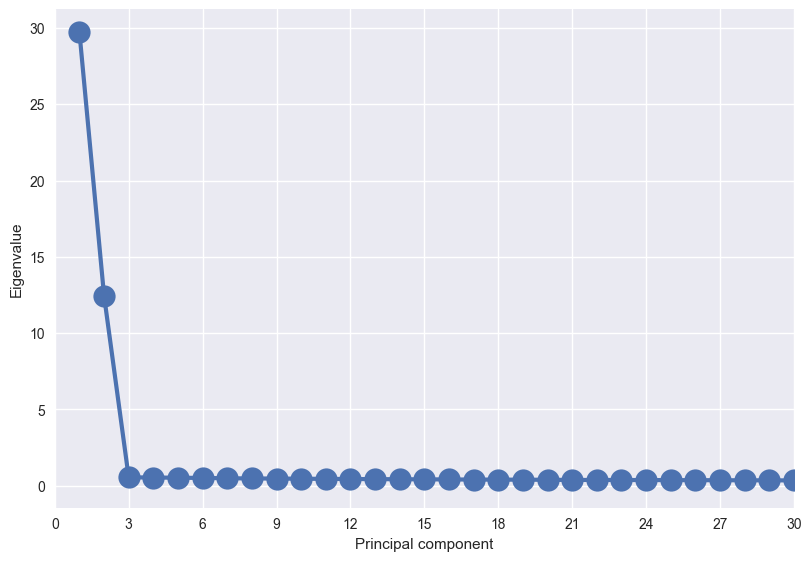

In [52]:
from psynlig import pca_scree
plt.clf()
plt.style.use('seaborn')
pca_scree(model_pca, marker='o', markersize=16, lw=3)
plt.rcParams.update({'font.size': 16})
plt.xlim([0, 30])
plt.show()

According to screeplot there is not much difference on eigenvalue after 3, therefore the number of components were set to three.

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [251] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Cleaning previous fitted model results..
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [251] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [1452] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [1452] unique colors! Available unique colors: [9].
[pc

<Figure size 800x550 with 0 Axes>

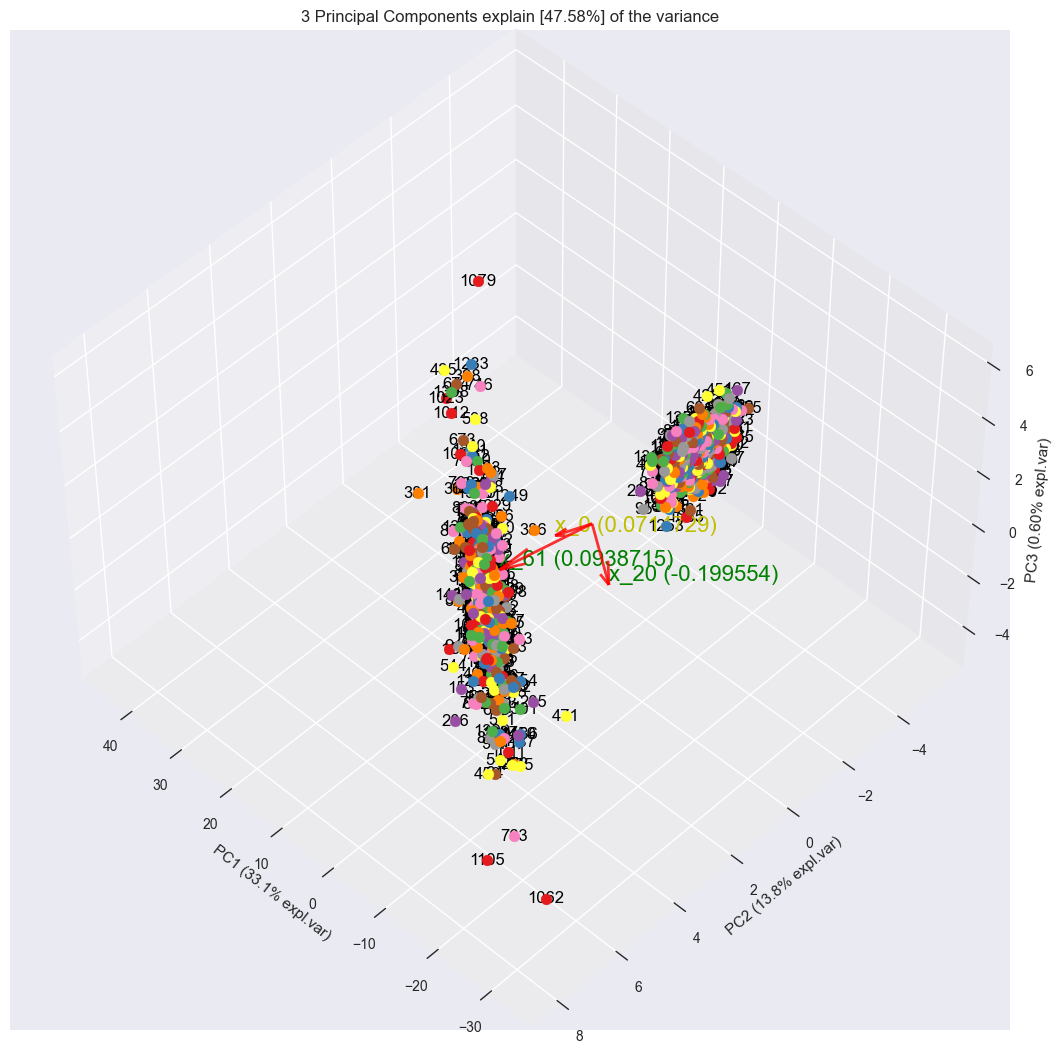

In [256]:
from pca import pca
plt.clf()
model_pca = pca(n_components=3)
pca_reduced_array = model_pca.fit_transform(x_train)
pca_df = pd.DataFrame(pca_reduced_array, index=x_train.index,columns=np.array([f"pca{num+1}" for num in range(2)]))
                      
result_pca = model_pca.fit_transform(x_train)
fig, ax = model_pca.biplot3d(n_feat=3, legend=False)
plt.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [80.0%] explained variance using the [251] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [98] that covers the [80.00%] explained variance.
[pca] >The PCA reduction is performed on the [251] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[98]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Cleaning previous fitted model results..
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [251] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[98]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[

<Figure size 800x550 with 0 Axes>

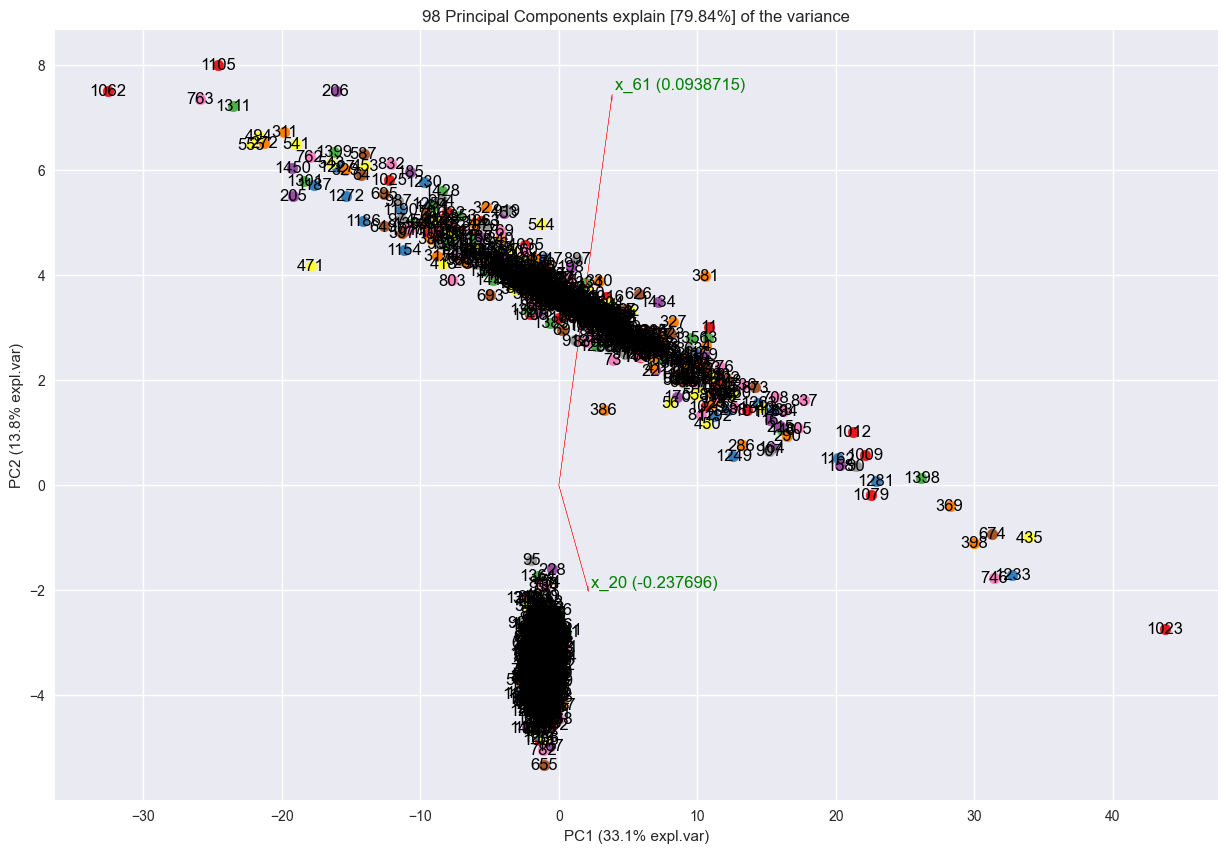

<Figure size 800x600 with 0 Axes>

In [57]:
plt.clf()
model_pca = pca(n_components=0.80)
pca_reduced_array = model_pca.fit_transform(x_train)
pca_df = pd.DataFrame(pca_reduced_array, index=x_train.index,columns=np.array([f"pca{num+1}" for num in range(2)]))
                      
result_pca = model_pca.fit_transform(x_train)
fig, ax = model_pca.biplot(n_feat=2, legend=False)
plt.figure(figsize=(8,6))
plt.show( )

<Figure size 800x550 with 0 Axes>

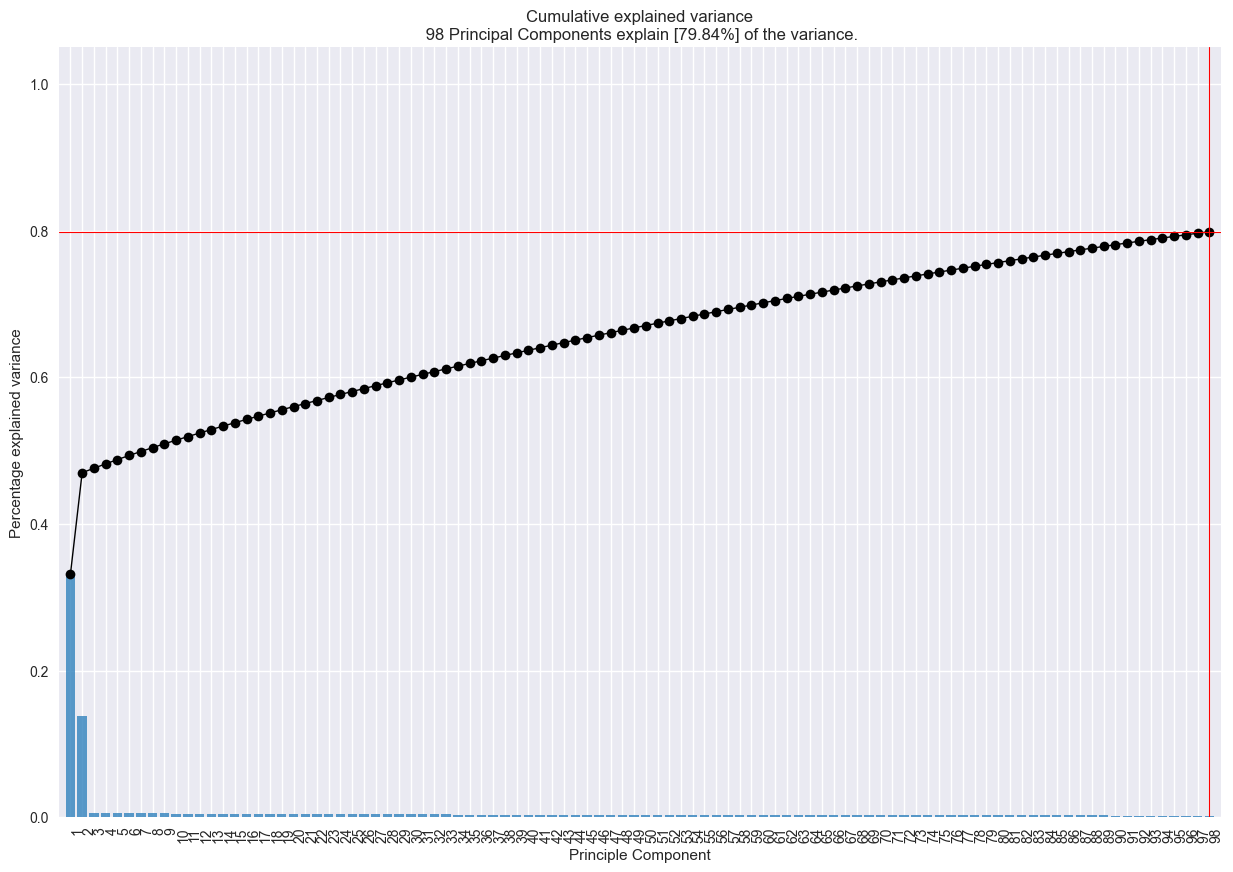

<Figure size 800x550 with 0 Axes>

In [253]:
plt.clf()
plt.show(model_pca.plot())

However, 3 components can not be used since the variance explained by 3 components is only 48% of the total variance. If the variance explained by the components needs to be over 80%, then at least 98 components need to be used. This discrepancy between significant eigenvalues and very small variance explained by marginal components makes it difficult to use PCA in the analysis. Therefore, the PCA was not used in this analysis as a demension reduction technique.

### 2) L1-based feature selection / Tree-based feature selection

citation: https://scikit-learn.org/stable/modules/feature_selection.html

- first, l1-regularized linear SVM and logistic regression was used to select features. In order to minimize the possibility of model overfit, cross-validation was adopted to choose best lambdas for l1-regularization.

In [7]:
# SVM: linear
from sklearn.svm import LinearSVC
model_svm_l_g = LinearSVC(penalty="l1", dual=False, random_state=2020, max_iter=20000)
parameters= {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Find Best Parameter C
model_svm_l = GridSearchCV(model_svm_l_g, param_grid = parameters, cv = cv_5, n_jobs=-1)

model_svc_fs= model_svm_l.fit(x_train2, y_train2)

In [8]:
model_svc_fs_result = pd.DataFrame(model_svc_fs.cv_results_['params'])
model_svc_fs_result['mean_accuracy_score'] = model_svc_fs.cv_results_['mean_test_score']
display(model_svc_fs_result.sort_values(by='mean_accuracy_score', ascending=False).head(5))

,C,mean_accuracy_score
1,0.010,0.648080
2,0.100,0.623004
0,0.001,0.566114
3,1.000,0.555101
4,10.000,0.531134


In [9]:
from sklearn.feature_selection import SelectFromModel
model_svc_l=LinearSVC(C= 0.01, penalty="l1", dual=False, random_state=2020, max_iter=20000)
model_svc_fs= model_svc_l.fit(x_train2, y_train2)
model_svc_final = SelectFromModel(model_svc_fs, prefit=True)

x_train3= model_svc_final.transform(x_train2)
print("original dataset: ", x_train2.shape,", feature selected: ", x_train3.shape)

original dataset:  (1452, 251) , feature selected:  (1452, 26)


In [10]:
# Logistic
model_lr_g= LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, dual=False, random_state=2020)
parameters= {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Find Best Parameter C
model_lr = GridSearchCV(model_lr_g, param_grid = parameters, cv = cv_5, n_jobs=-1)

model_lr_fs= model_lr.fit(x_train2, y_train2)

In [11]:
model_lr_fs_result = pd.DataFrame(model_lr_fs.cv_results_['params'])
model_lr_fs_result['mean_accuracy_score'] = model_lr_fs.cv_results_['mean_test_score']
display(model_lr_fs_result.sort_values(by='mean_accuracy_score', ascending=False).head(5))

,C,mean_accuracy_score
2,0.100,0.644903
1,0.010,0.590767
3,1.000,0.571637
0,0.001,0.566114
4,10.000,0.528654


In [12]:
model_lr= LogisticRegression(penalty='l1',C=0.1,multi_class='multinomial', solver='saga', max_iter=10000, dual=False, random_state=2020)
model_lr_fs= model_lr.fit(x_train2, y_train2)
model_lr_final = SelectFromModel(model_lr_fs, prefit=True)

x_train4= model_lr_final.transform(x_train2)
print("original dataset: ", x_train2.shape,", feature selected: ", x_train4.shape)

original dataset:  (1452, 251) , feature selected:  (1452, 60)


In [13]:
# Tree-based
from sklearn.ensemble import ExtraTreesClassifier

In [14]:
model_et_g= ExtraTreesClassifier(n_estimators=50, max_features='sqrt', random_state=2022)

# use a full grid over all parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': np.arange(25,175,50).tolist(),
    'max_depth' : [1,3,5,7],
    'max_features': [5,10]+np.arange(1,180,30).tolist()
}

# run grid search
model_et = GridSearchCV(model_et_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1)
start = time()
model_et.fit(x_train2, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_et.cv_results_["params"]))
)
report(model_et.cv_results_)

Fitting 25 folds for each of 192 candidates, totalling 4800 fits
GridSearchCV took 126.86 seconds for 192 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.644 (std: 0.017)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 121, 'n_estimators': 125}

Model with rank: 2
Mean validation score: 0.644 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 121, 'n_estimators': 125}

Model with rank: 3
Mean validation score: 0.644 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 151, 'n_estimators': 25}



In [15]:
model_et= ExtraTreesClassifier(criterion= 'entropy', max_features=121, n_estimators= 125, max_depth=3 , random_state=2022)
model_et_fs= model_et.fit(x_train2, y_train2)
model_et_final = SelectFromModel(model_et_fs, prefit=True)

x_train4= model_et_final.transform(x_train2)
print("original dataset: ", x_train2.shape,", feature selected: ", x_train4.shape)

original dataset:  (1452, 251) , feature selected:  (1452, 45)


The features that are selected in at least two of the each selection methods were included in the final feature selection.

In [16]:
features = pd.DataFrame([model_lr_final.fit(x_train2,y_train2).get_support(), model_svc_final.fit(x_train2,y_train2).get_support(),model_et_final.fit(x_train2,y_train2).get_support()],
                        index=["LR","SVM","ET"]).T

features1=pd.DataFrame(features[(features["LR"] == True)|(features["SVM"] == True)|(features["ET"] == True)].sum(axis=1)>1, columns=["features"])
print("features chosen: ", features1[features1["features"]==True].shape)
features2=features1[features1["features"]==True]
with np.printoptions(threshold=np.inf):
    print("selected features:",np.array(features2.index))

features chosen:  (27, 1)
selected features: [  2  17  22  28  30  38  44  49  61  64  70  79  90 104 113 129 134 145
 169 172 177 190 193 207 228 231 246]


### 3) Re-estimation with selected features
Using selected features, the crossvalidation accuracy and f1_scores for the models without feature selection was calculated again <br>
(logistic, linear svm, quadratic svm, knn, random forest, gbm, xgboost, lda, qda )

In [17]:
# selection
x_train_fs=x_train.iloc[:,features2.index]
x_train5=x_train_fs.to_numpy()
x_train5.shape

(1452, 27)

<Figure size 640x480 with 0 Axes>

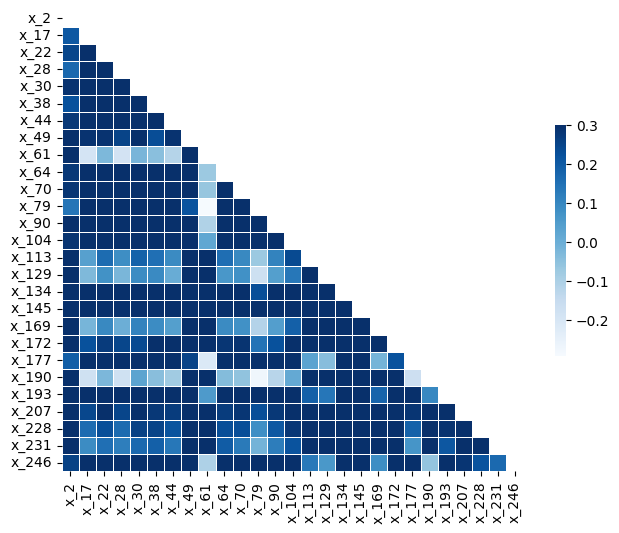

In [41]:
plt.clf()
corr=x_train_fs.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


#### - multinomial logit

In [43]:
# multinomial logistic 
model_lr_f= LogisticRegression(C=0.01,multi_class='multinomial', max_iter=10000, dual=False, random_state=2020)
accuracy_lr_f = cross_val_score(model_lr_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_lr_f= cross_val_score(model_lr_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1 weighted: %.3f (%.3f)' % (np.mean(f1w_lr_f), np.std(f1w_lr_f)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_lr_f), np.std(accuracy_lr_f)))


Mean f1 weighted: 0.568 (0.018)
Mean Accuracy: 0.647 (0.016)


#### - linear svm

In [44]:
# linear svm
model_svcl_f = LinearSVC(C= 0.01 , penalty="l1", dual=False, random_state=2020, max_iter=20000)
accuracy_svcl_f = cross_val_score(model_svcl_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_svcl_f= cross_val_score(model_svcl_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1 weighted: %.3f (%.3f)' % (np.mean(f1w_svcl_f), np.std(f1w_svcl_f)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_svcl_f), np.std(accuracy_svcl_f)))


Mean f1 weighted: 0.563 (0.018)
Mean Accuracy: 0.648 (0.015)


#### - rbf svm

In [66]:
# quadratic svm
model_svcq_g = SVC(kernel='rbf', random_state=2022, max_iter=22000)
parameters= {'C': [500, 600, 650, 700, 750, 800, 900], 'gamma': [0.00004,0.00006,0.00008, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001]}

# Find Best Parameter C and gamma
model_svcq_f = GridSearchCV(model_svcq_g, verbose=2, param_grid = parameters, cv = cv_5, n_jobs=-1,scoring='f1_weighted')
model_svcq_f.fit(x_train5, y_train2)

Fitting 25 folds for each of 63 candidates, totalling 1575 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=2022),
             estimator=SVC(max_iter=22000, random_state=2022), n_jobs=-1,
             param_grid={'C': [500, 600, 650, 700, 750, 800, 900],
                         'gamma': [4e-05, 6e-05, 8e-05, 0.0001, 0.0002, 0.0003,
                                   0.0004, 0.0005, 0.001]},
             scoring='f1_weighted', verbose=2)

In [68]:
model_svcq_f_result = pd.DataFrame(model_svcq_f.cv_results_['params'])
model_svcq_f_result['mean_f1_weighted_score'] = model_svcq_f.cv_results_['mean_test_score']
model_svcq_f_result['std_f1_weighted_score'] = model_svcq_f.cv_results_['std_test_score']
display(model_svcq_f_result.sort_values(by='mean_f1_weighted_score', ascending=False).head(5))

,C,gamma,mean_f1_weighted_score,std_f1_weighted_score
15,600,0.0004,0.568534,0.019032
50,800,0.0003,0.568374,0.019318
52,800,0.0005,0.568364,0.018764
51,800,0.0004,0.568262,0.019490
24,650,0.0004,0.568231,0.019152


In [71]:
model_svcq_f = SVC(kernel='rbf',C=600,gamma=0.0004, random_state=2022)

# evaluate the model and collect the scores
accuracy_svcq_f= cross_val_score(model_svcq_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_svcq_f= cross_val_score(model_svcq_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_svcq_f), np.std(f1w_svcq_f)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_svcq_f), np.std(accuracy_svcq_f)))

Mean f1_weighted: 0.569 (0.019)
Mean Accuracy: 0.651 (0.018)


#### - knn

In [74]:
# build a classifier
model_knn_g = KNeighborsClassifier()

# use a full grid over all parameters
param_grid = {
    'n_neighbors' : np.arange(1,30).tolist(),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}


# run grid search
model_knn = GridSearchCV(model_knn_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring='f1_weighted')
start = time()
model_knn.fit(x_train5, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_knn.cv_results_["params"]))
)
report(model_knn.cv_results_)

Fitting 25 folds for each of 174 candidates, totalling 4350 fits
GridSearchCV took 5.55 seconds for 174 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.605 (std: 0.024)
Parameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.604 (std: 0.026)
Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.604 (std: 0.021)
Parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.604 (std: 0.021)
Parameters: {'metric': 'minkowski', 'n_neighbors': 19, 'weights': 'distance'}



In [75]:
model_knn_f = KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')

# evaluate the model and collect the scores
accuracy_knn_f= cross_val_score(model_knn_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_knn_f= cross_val_score(model_knn_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_knn_f), np.std(f1w_knn_f)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_knn_f), np.std(accuracy_knn_f)))

Mean f1_weighted: 0.605 (0.024)
Mean Accuracy: 0.635 (0.020)


#### - SGD classifier

In [76]:
# SGD classifier
# build a classifier
model_sgd_g = SGDClassifier(fit_intercept=True, max_iter=30000, alpha=0.1)

# use a full grid over all parameters
param_grid = {
    "average": [True, False],
    'loss': ['hinge','log_loss','modified_huber','perceptron','squared_hinge'], 
    'penalty': ['l2', 'l1', 'elasticnet'],
    'l1_ratio': np.arange(0.3,0.7,0.1)
}

# run grid search
model_sgd = GridSearchCV(model_sgd_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring='f1_weighted')
start = time()
model_sgd.fit(x_train5, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_sgd.cv_results_["params"]))
)
report(model_sgd.cv_results_)


Fitting 25 folds for each of 120 candidates, totalling 3000 fits
GridSearchCV took 802.35 seconds for 120 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.583 (std: 0.032)
Parameters: {'average': True, 'l1_ratio': 0.5, 'loss': 'squared_hinge', 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.577 (std: 0.031)
Parameters: {'average': True, 'l1_ratio': 0.6000000000000001, 'loss': 'squared_hinge', 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.576 (std: 0.019)
Parameters: {'average': True, 'l1_ratio': 0.3, 'loss': 'perceptron', 'penalty': 'l2'}



In [77]:
model_sgd_result = pd.DataFrame(model_sgd.cv_results_['params'])
model_sgd_result['mean_f1_weighted_score'] = model_sgd.cv_results_['mean_test_score']
model_sgd_result['std_f1_weighted_score'] = model_sgd.cv_results_['std_test_score']
display(model_sgd_result.sort_values(by='mean_f1_weighted_score', ascending=False).head(5))

,average,l1_ratio,loss,penalty,mean_f1_weighted_score,std_f1_weighted_score
42,True,0.5,squared_hinge,l2,0.582982,0.031619
57,True,0.6,squared_hinge,l2,0.577381,0.031336
9,True,0.3,perceptron,l2,0.576001,0.019470
54,True,0.6,perceptron,l2,0.575578,0.017628
24,True,0.4,perceptron,l2,0.574806,0.020559


In [79]:
model_sgd_f = SGDClassifier(max_iter=30000, average=True, alpha=0.1, l1_ratio=0.5, loss='perceptron', penalty='l2')

# evaluate the model and collect the scores
accuracy_sgd_f = cross_val_score(model_sgd_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_sgd_f = cross_val_score(model_sgd_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_sgd_f), np.std(f1w_sgd_f)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_sgd_f), np.std(accuracy_sgd_f)))

Mean f1_weighted: 0.572 (0.019)
Mean Accuracy: 0.644 (0.017)


#### - random forest

In [81]:
# build a classifier
model_rf_g = RandomForestClassifier(random_state=2022)

# use a full grid over all parameters
param_grid = {
    'n_estimators': [200, 500],
    'max_depth' : [2,4,6,8,10],
    'criterion' :['gini', 'entropy']
}

# run grid search
model_rf = GridSearchCV(model_rf_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring='f1_weighted')
start = time()
model_rf.fit(x_train5, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_rf.cv_results_["params"]))
)
report(model_rf.cv_results_)

Fitting 25 folds for each of 20 candidates, totalling 500 fits
GridSearchCV took 85.33 seconds for 20 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.593 (std: 0.024)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.593 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.592 (std: 0.023)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}



In [82]:
model_rf_f = RandomForestClassifier(criterion="entropy", max_depth=10, n_estimators=200,random_state=2020)

# evaluate the model and collect the scores
accuracy_rf_f = cross_val_score(model_rf_f , x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_rf_f = cross_val_score(model_rf_f , x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted: %.3f (%.3f)' % (np.mean(f1w_rf_f), np.std(f1w_rf_f)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(accuracy_rf_f), np.std(accuracy_rf_f)))


Mean f1_weighted: 0.594 (0.023)
Mean Accuracy: 0.640 (0.017)


#### - gradient boosting tree

In [83]:
# build a classifier
model_bt_g = GradientBoostingClassifier(random_state=2022,loss='log_loss', n_iter_no_change = 10)

# use a full grid over all parameters
param_grid = {
    'n_estimators': np.arange(25,225,50).tolist(),
    'max_depth' : [2,3,4],
    'learning_rate': [0.01,0.05],
    'max_features': np.arange(5,32,5).tolist()
}

# run grid search
model_bt = GridSearchCV(model_bt_g, verbose= 1, param_grid=param_grid, cv=cv_5, n_jobs=-1, scoring='f1_weighted')
start = time()
model_bt.fit(x_train5, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_bt.cv_results_["params"]))
)
report(model_bt.cv_results_)

Fitting 25 folds for each of 144 candidates, totalling 3600 fits
GridSearchCV took 412.38 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.599 (std: 0.024)
Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 15, 'n_estimators': 175}

Model with rank: 2
Mean validation score: 0.599 (std: 0.025)
Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 15, 'n_estimators': 125}

Model with rank: 3
Mean validation score: 0.599 (std: 0.024)
Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 15, 'n_estimators': 75}



In [84]:
model_bt_f = GradientBoostingClassifier(random_state=2022,loss='log_loss', learning_rate=0.05, max_depth=2, max_features=15, n_estimators=175)

# evaluate the model and collect the scores
accuracy_bt_f= cross_val_score(model_bt_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_bt_f= cross_val_score(model_bt_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted bt: %.3f (%.3f)' % (np.mean(f1w_bt_f), np.std(f1w_bt_f)))
print('Mean Accuracy bt: %.3f (%.3f)' % (np.mean(accuracy_bt_f), np.std(accuracy_bt_f)))

Mean f1_weighted bt: 0.602 (0.022)
Mean Accuracy bt: 0.642 (0.021)


#### - xgboost

In [95]:
# build a classifier
model_xgb_g = XGBClassifier(random_state=2022, objective='multi:softmax',num_class=3, n_estimators=25, learning_rate=0.1, max_depth=3)

# use a full grid over all parameters
param_grid = {
    'gamma' : np.arange(0,1.2,0.1).tolist(),
    'alpha' : np.arange(0.5,1.5,0.1).tolist(),
    'lambda' : np.arange(0.5,1.5,0.1).tolist()
}

# run grid search
model_xgb = GridSearchCV(model_xgb_g, verbose= 3, param_grid=param_grid, cv=cv_5,n_jobs=-1, scoring='f1_weighted')
start = time()
model_xgb.fit(x_train5, y_train2)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_xgb.cv_results_["params"]))
)
report(model_xgb.cv_results_)

Fitting 25 folds for each of 1200 candidates, totalling 30000 fits
GridSearchCV took 913.40 seconds for 1200 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.601 (std: 0.024)
Parameters: {'alpha': 0.5, 'gamma': 0.30000000000000004, 'lambda': 0.6}

Model with rank: 2
Mean validation score: 0.601 (std: 0.025)
Parameters: {'alpha': 0.5, 'gamma': 0.2, 'lambda': 0.6}

Model with rank: 3
Mean validation score: 0.600 (std: 0.025)
Parameters: {'alpha': 0.5, 'gamma': 0.0, 'lambda': 0.6}

Model with rank: 3
Mean validation score: 0.600 (std: 0.025)
Parameters: {'alpha': 0.5, 'gamma': 0.1, 'lambda': 0.6}



In [97]:
model_xgb_f = XGBClassifier(random_state=2022, objective='multi:softmax',num_class=3, n_estimators=25, learning_rate=0.1, max_depth=3,alpha=0.5, gamma=0.3, get_lambda=0.6)

# evaluate the model and collect the scores
accuracy_xgb_f = cross_val_score(model_xgb_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_xgb_f = cross_val_score(model_xgb_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted xgb: %.3f (%.3f)' % (np.mean(f1w_xgb_f), np.std(f1w_xgb_f)))
print('Mean Accuracy xgb: %.3f (%.3f)' % (np.mean(accuracy_xgb_f), np.std(accuracy_xgb_f)))


Mean f1_weighted xgb: 0.597 (0.024)
Mean Accuracy xgb: 0.645 (0.018)


#### - linear discriminant analysis

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [21]:
model_lda_g = LinearDiscriminantAnalysis()
parameters= {
    'solver': ['lsqr', 'eigen'], 
    'shrinkage': ['auto']+np.arange(0.1,0.9,0.1).tolist()
    }

# run grid search
model_lda = GridSearchCV(model_lda_g, verbose= 1, param_grid=parameters, cv=cv_5, n_jobs=-1, scoring="f1_weighted")
start = time()
model_lda.fit(x_train5, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_lda.cv_results_["params"]))
)
report(model_lda.cv_results_)

Fitting 25 folds for each of 18 candidates, totalling 450 fits
GridSearchCV took 0.53 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.625 (std: 0.022)
Parameters: {'shrinkage': 0.5, 'solver': 'lsqr'}

Model with rank: 1
Mean validation score: 0.625 (std: 0.022)
Parameters: {'shrinkage': 0.5, 'solver': 'eigen'}

Model with rank: 3
Mean validation score: 0.624 (std: 0.020)
Parameters: {'shrinkage': 0.4, 'solver': 'lsqr'}

Model with rank: 3
Mean validation score: 0.624 (std: 0.020)
Parameters: {'shrinkage': 0.4, 'solver': 'eigen'}



In [22]:
model_lda_f = LinearDiscriminantAnalysis(shrinkage=0.5,solver='lsqr')

# evaluate the model and collect the scores
accuracy_lda_f = cross_val_score(model_lda_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_lda_f = cross_val_score(model_lda_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted lda: %.3f (%.3f)' % (np.mean(f1w_lda_f), np.std(f1w_lda_f)))
print('Mean Accuracy lda: %.3f (%.3f)' % (np.mean(accuracy_lda_f), np.std(accuracy_lda_f)))

Mean f1_weighted lda: 0.625 (0.022)
Mean Accuracy lda: 0.633 (0.023)


#### - quadratic discriminant analysis

In [103]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [104]:
model_qda_g = QuadraticDiscriminantAnalysis()
parameters= {'reg_param': np.arange(0,1,0.1).tolist()}

# run grid search
model_qda = GridSearchCV(model_qda_g, verbose= 1, param_grid=parameters, cv=cv_5, n_jobs=-1, scoring='f1_weighted')
start = time()
model_qda.fit(x_train5, y_train2)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(model_qda.cv_results_["params"]))
)
report(model_qda.cv_results_)

Fitting 25 folds for each of 10 candidates, totalling 250 fits
GridSearchCV took 0.25 seconds for 10 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.626 (std: 0.022)
Parameters: {'reg_param': 0.9}

Model with rank: 2
Mean validation score: 0.626 (std: 0.022)
Parameters: {'reg_param': 0.8}

Model with rank: 3
Mean validation score: 0.624 (std: 0.025)
Parameters: {'reg_param': 0.7000000000000001}



In [105]:
model_qda_f = QuadraticDiscriminantAnalysis(reg_param=0.8)

# evaluate the model and collect the scores
accuracy_qda_f = cross_val_score(model_qda_f, x_train5, y_train2, scoring='accuracy', cv=cv_5, n_jobs=-1)
f1w_qda_f = cross_val_score(model_qda_f, x_train5, y_train2, scoring='f1_weighted', cv=cv_5, n_jobs=-1)

# report the model performance
print('Mean f1_weighted qda: %.3f (%.3f)' % (np.mean(f1w_qda_f), np.std(f1w_qda_f)))
print('Mean Accuracy qda: %.3f (%.3f)' % (np.mean(accuracy_qda_f), np.std(accuracy_qda_f)))


Mean f1_weighted qda: 0.626 (0.022)
Mean Accuracy qda: 0.627 (0.023)


# 2. 
Based on your training results in Problem 1, you now pick your best model that would generalize well to unseen data. Using your best model, we are going to predict on the provided test dataset, OnlineAd X test.csv which contains 300 observations with 251 features. Here we do not have the corresponding responses for these test observations.


## (a) 
[20 pts] Report the estimated test performance for your best model. Provide a
reason for your choice of a model among the models you considered.

In [125]:
result=pd.DataFrame({"multinomial logistic": [np.mean(f1w_lr_f),np.std(f1w_lr_f),np.mean(accuracy_lr_f),np.std(accuracy_lr_f)],
             "linear svm":[np.mean(f1w_svcl_f), np.std(f1w_svcl_f),np.mean(accuracy_svcl_f), np.std(accuracy_svcl_f)],
             "rbf svm":[np.mean(f1w_svcq_f), np.std(f1w_svcq_f),np.mean(accuracy_svcq_f), np.std(accuracy_svcq_f)],
             "knn":[np.mean(f1w_knn_f), np.std(f1w_knn_f),np.mean(accuracy_knn_f), np.std(accuracy_knn_f)],
             "sgd classifier":[np.mean(f1w_sgd_f), np.std(f1w_sgd_f),np.mean(accuracy_sgd_f), np.std(accuracy_sgd_f)],
             "ramdom forest":[np.mean(f1w_rf_f), np.std(f1w_rf_f),np.mean(accuracy_rf_f), np.std(accuracy_rf_f)],
             "gradient boosted tree": [np.mean(f1w_bt_f), np.std(f1w_bt_f),np.mean(accuracy_bt_f), np.std(accuracy_bt_f)],
             "xgboost": [np.mean(f1w_xgb_f), np.std(f1w_xgb_f),np.mean(accuracy_xgb_f), np.std(accuracy_xgb_f)],
             "linear discriminant analysis":[np.mean(f1w_lda_f), np.std(f1w_lda_f),np.mean(accuracy_lda_f), np.std(accuracy_lda_f)],
             "quadratic discriminant analysis":[np.mean(f1w_qda_f), np.std(f1w_qda_f),np.mean(accuracy_qda_f), np.std(accuracy_qda_f)] },
    index=["Mean F1 weighted", "Std F1 weighted","Mean Accuracy Score","Std Accuracy Score"]).round(3)
result.index.name='5-fold CV / feature selected (n=27)'
result=result.T
result["mean"] = result.iloc[:, [0,2]].mean(axis=1)
display(result.sort_values(by='mean', ascending=False).round(3))

5-fold CV / feature selected (n=27),Mean F1 weighted,Std F1 weighted,Mean Accuracy Score,Std Accuracy Score,mean
linear discriminant analysis,0.625,0.022,0.633,0.023,0.629
quadratic discriminant analysis,0.626,0.022,0.627,0.023,0.626
gradient boosted tree,0.602,0.022,0.642,0.021,0.622
xgboost,0.597,0.024,0.645,0.018,0.621
knn,0.605,0.024,0.635,0.020,0.620
ramdom forest,0.594,0.023,0.640,0.017,0.617
rbf svm,0.569,0.019,0.651,0.018,0.610
sgd classifier,0.572,0.019,0.644,0.017,0.608
multinomial logistic,0.568,0.018,0.647,0.016,0.607
linear svm,0.563,0.018,0.648,0.015,0.605


## (b)
[20 pts] Predict on the provided test dataset, OnlineAd_X_test.csv, and save those predictions as a CSV file named [your-student-ID] pred.csv. The CSV file should only contain the array of dimension [300, 3] in the same format as the OnlineAd_Y_train.csv except the number of rows, since there are only 300 observations in the test data, i.e., the first column corresponds to no click, the second column corresponds to the ad A, and the third column corresponds to the ad B. A violation of this format guideline will result in 10 point penalty.



In [18]:
x_test2 = x_test.iloc[:,features2.index].to_numpy()

In [23]:
# choosed gradient boosted tree
model_lda_f.fit(x_train5, y_train2)
prediction = model_lda_f.predict(x_test2)

In [26]:
print(Counter(y_train2))
print(Counter(prediction))

Counter({0: 822, 2: 353, 1: 277})
Counter({0: 188, 2: 65, 1: 47})


In [27]:
prediction_comp=pd.DataFrame({0: [822,188], 1: [277,47], 2: [353,65]})
prediction_comp

,0,1,2
0,822,277,353
1,188,47,65


In [28]:
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(prediction_comp.to_numpy())
print(f"chi-squared: {chi}",
      f"p-value (0.05): {p}",
      f"degree of freedom: {dof}",
      f"expectation: \n{pd.DataFrame(expected)}")
# It cannot be rejected that real clicks and the classifications are from different distributions (only if the tested data is randomly selected from the same distribution of training data)

chi-squared: 3.8738967610162973 p-value (0.05): 0.1441431493460496 degree of freedom: 2 expectation: 
            0           1           2
0  837.054795  268.520548  346.424658
1  172.945205   55.479452   71.575342


In [259]:
prediction_df=pd.DataFrame({0:np.where(prediction==0,1,0), 1:np.where(prediction==1,1,0), 2:np.where(prediction==2,1,0)})
prediction_df.to_csv("E:/OneDrive - SNU/(B) 대학원/수업/2022 2학기/데이터사이언스를위한머신러닝과딥러닝/과제2/OnlineAd_Y_test.csv",index=False, header=False)